# Covid19 Chest Xray-Image Classification With A Convolutional Neural Network (CNN) Model and Hybrid CNN-Support Vector Machine Model  

In [1]:
import os
from google.colab import files
from PIL import Image
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers
from tensorflow.keras.initializers import LecunNormal
from keras.models import Model
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, Activation
from keras.layers.noise import AlphaDropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [2]:
# Set paths
main_dir = '/content/drive/MyDrive/covidData/Data'
train_dir = os.path.join(main_dir, 'train')
test_dir = os.path.join(main_dir, 'test')

train_covid_dir = os.path.join(train_dir, 'COVID19')
train_normal_dir = os.path.join(train_dir, 'NORMAL')
test_covid_dir = os.path.join(test_dir, 'COVID19')
test_normal_dir = os.path.join(test_dir, 'NORMAL')

# saved models (non callback)
default_saved_dir = '/content/drive/MyDrive/covidData/Saved_Model'
CNN_saved_dir = '/content/drive/MyDrive/covidData/Saved_CNN_Model'
CNNSVM_saved_dir = '/content/drive/MyDrive/covidData/Saved_CNNSVM_Model'

# images to manually test model 
testing_data = '/content/drive/MyDrive/covidData/Data/test_data'

# Display filenames
train_covid_names = os.listdir(train_covid_dir)
print(train_covid_names[:10])
train_normal_names = os.listdir(train_normal_dir)
print(train_normal_names[:10])

test_covid_names = os.listdir(test_covid_dir)
print(test_covid_names[:10])
test_normal_names = os.listdir(test_normal_dir)
print(test_normal_names[:10])

# Print the number of images in each directory
print("\ntotal images present in traning set: ", len(train_covid_names+train_normal_names))
print("total images prsent in testing set: ", len(test_covid_names+test_normal_names))

# Load an image and get properties
img = Image.open('/content/drive/MyDrive/covidData/Data/train/COVID19/COVID-19 (18).jpeg')
print("\n",img.format)
print(img.mode)
print(img.size)

['COVID-19 (161).jpg', 'COVID-19 (101).jpg', 'COVID-19 (12).jpeg', 'COVID-19 (13).jpeg', 'COVID-19 (15).jpeg', 'COVID-19 (11).jpg', 'COVID-19 (159).jpg', 'COVID-19 (12).jpg', 'COVID-19 (14).jpeg', 'COVID-19 (169).jpg']
['NORMAL(1303).jpg', 'NORMAL(1304).jpg', 'NORMAL(1315).jpg', 'NORMAL(130).jpg', 'NORMAL(1312).jpg', 'NORMAL(1308).jpg', 'NORMAL(1316).jpg', 'NORMAL(1310).jpg', 'NORMAL(1311).jpg', 'NORMAL(1307).jpg']
['COVID-19 (551).jpg', 'COVID-19 (439).jpg', 'COVID-19 (817).jpg', 'COVID-19 (425).jpg', 'COVID-19 (475).jpg', 'COVID-19 (570).jpg', 'COVID-19 (353).jpg', 'COVID-19 (587).jpg', 'COVID-19 (457).jpg', 'COVID-19 (839).jpg']
['NORMAL(1044).jpg', 'NORMAL(1020).jpg', 'NORMAL(1052).jpg', 'NORMAL(1043).jpg', 'NORMAL(1012).jpg', 'NORMAL(1037).jpg', 'NORMAL(1023).jpg', 'NORMAL(1070).jpg', 'NORMAL(10).jpg', 'NORMAL(1011).jpg']

total images present in traning set:  1811
total images prsent in testing set:  484

 JPEG
L
(1024, 1024)


# Data Visualisation

['/content/drive/MyDrive/covidData/Data/train/COVID19/COVID-19 (161).jpg', '/content/drive/MyDrive/covidData/Data/train/COVID19/COVID-19 (101).jpg', '/content/drive/MyDrive/covidData/Data/train/COVID19/COVID-19 (12).jpeg', '/content/drive/MyDrive/covidData/Data/train/COVID19/COVID-19 (13).jpeg', '/content/drive/MyDrive/covidData/Data/train/COVID19/COVID-19 (15).jpeg', '/content/drive/MyDrive/covidData/Data/train/COVID19/COVID-19 (11).jpg', '/content/drive/MyDrive/covidData/Data/train/COVID19/COVID-19 (159).jpg', '/content/drive/MyDrive/covidData/Data/train/COVID19/COVID-19 (12).jpg']
['/content/drive/MyDrive/covidData/Data/train/NORMAL/NORMAL(1303).jpg', '/content/drive/MyDrive/covidData/Data/train/NORMAL/NORMAL(1304).jpg', '/content/drive/MyDrive/covidData/Data/train/NORMAL/NORMAL(1315).jpg', '/content/drive/MyDrive/covidData/Data/train/NORMAL/NORMAL(130).jpg', '/content/drive/MyDrive/covidData/Data/train/NORMAL/NORMAL(1312).jpg', '/content/drive/MyDrive/covidData/Data/train/NORMAL/NO

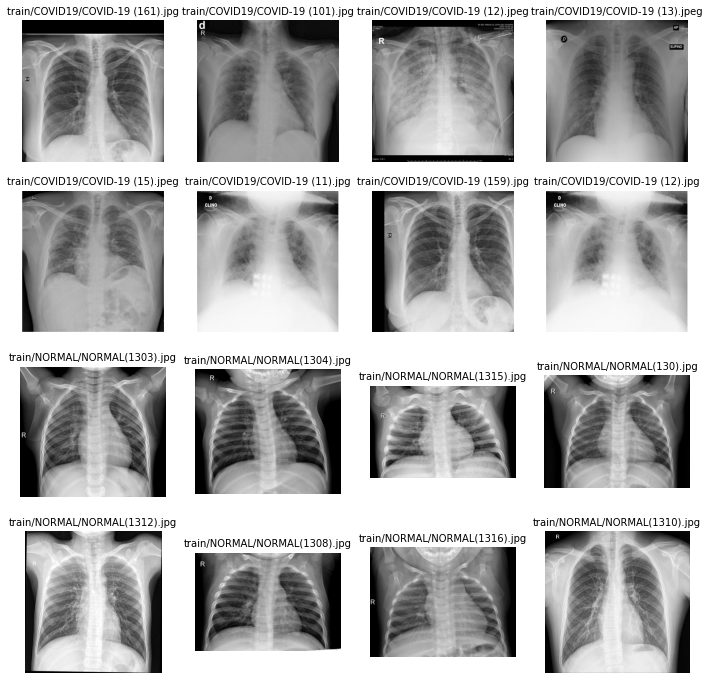

In [3]:
# Plot a grid of 16 images (8 images of Covid19 and 8 images of Normal)
# Set the number of cols & rows
rows = 4
cols = 4
# set figure size
# get current figure
fig = plt.gcf()     
fig.set_size_inches(12,12)
# Get filenames from Covid & Normal dir of train dataset
# Iterate over train set and take 8 images, and store in list
covid_pic = [os.path.join(train_covid_dir, filename) for filename in train_covid_names[0:8]]
normal_pic = [os.path.join(train_normal_dir, filename) for filename in train_normal_names[0:8]]

# Print list
print(covid_pic)
print(normal_pic)

# Merge covid and normal lists
merged_list = covid_pic+normal_pic

# Return index and image path of each, with most of path removed. Then display
for i , img_path in enumerate(merged_list): 
  data = img_path.split('/',6)[6]
  sp = plt.subplot(rows, cols,i+1)
  sp.axis('Off')
  img = mpimg.imread(img_path)
  sp.set_title(data, fontsize=10)
# Set image to gray 
  plt.imshow(img, cmap='gray')

plt.show()  

# Data Preprocessing & Augmentation


Keras Preprocessing:
ImageDataGenerator generates batches of tensor image data with real-time data augmentation. The dataset is looped over in each epoch and images in dataset are transformed as per options selected. This enables more opportunity to identify patterns. This happens in memory so no further storage required.

- rescale: normalise pixel values for processing.
- validation: randomly split a subset of training data into a validation set, specified by the given percentage (20% validation, 80% training).
- zoom: allow random crops from images from zooming in. (Set as 20%).
- horizontal_flip: flip the image horizontally 

Generator:
    To create generated functions, the flow method is called on the dgen objects.
- target_size: the size to rescale pixels.
- subset: trained with training subset, validated with validation subset (Divided 80% / 20% - set in validation_split).
- batch_size: amount of images fed at once.
- class_mode: set to binary as only two output classes. If using more datatypes; use 'categorical'.

In [ ]:
dgen_train = ImageDataGenerator(rescale = 1./255,
                                validation_split=0.2,
                                zoom_range = 0.2,
                                horizontal_flip = True
                                )

dgen_validation = ImageDataGenerator(rescale = 1./255)
dgen_test = ImageDataGenerator(rescale = 1./255)

# batchs of data from each dir to be passed into sequntial model
train_generator = dgen_train.flow_from_directory(train_dir, 
                                                 target_size=(150,150),
                                                 subset = 'training',
                                                 batch_size = 32,
                                                 class_mode = 'binary')

validation_generator = dgen_train.flow_from_directory(train_dir, 
                                                 target_size=(150,150),
                                                 subset = 'validation',
                                                 batch_size = 32,
                                                 class_mode = 'binary')

test_generator = dgen_test.flow_from_directory(test_dir, 
                                                 target_size=(150,150),
                                                 batch_size = 32,
                                                 class_mode = 'binary')
# catergories 
train_generator.class_indices
# display image shape (dimension pixels and channel attribute (3 = RGB, 1 = Greyscale))
train_generator.image_shape

Found 1449 images belonging to 2 classes.
Found 362 images belonging to 2 classes.
Found 484 images belonging to 2 classes.


(150, 150, 3)

# Building The Model

Keras Layers:
- Conv2D: first layer to extract features from input image.

 - it observes the relationship between pixels and image features using a Kernel to slide over image pixels and identify patterns.

 - This helps with sharpening & detection & learn characteristics of an image. will transform the input image into an abstract representation this is then used by the Dense connected layer to generate a classification (this dense only handle a 1d data, so must convert with Flatten).
- MaxPool2D: helps reduce the sight of data and prevent overfitting.
- Dropout: drop neurons to reduce over-fitting.
- Flatten: transforms the 2D matrix into a vector (1D), that can be fed into a fully connected neural network classifier.
- Dense: fully connected layer (dense layer) class of a fully connected neural network layers where each input node is connected to where each input node is connected to each output node (Dense is used to predict the labels).

Convolutional Nerual Network (CNN) Model:

In [ ]:
# Sequential groups a linear stack of layers into a Model
CNNmodel = Sequential()

# Kernel size 5x5, with same padding. Then add relu non-linearity and input shape
# Strides are default(1,1)
CNNmodel.add(Conv2D(32,(5,5),padding='SAME', activation='relu', input_shape=(150,150, 3)))             
# Pooling layer - to reduce dimensionality. size reduced to reduce parameters and training time
CNNmodel.add(MaxPool2D(pool_size=(2, 2)))
# Place a dropout layer (drop 50% of neurons to not over-fit the data)
CNNmodel.add(Dropout(0.5))

# Add another convolutional layer - with increased size
CNNmodel.add(Conv2D(64, (5, 5), padding='SAME', activation='relu'))
CNNmodel.add(MaxPool2D(pool_size=(2, 2)))
CNNmodel.add(Dropout(0.5))

# Flatten layer - convert image from 2d to 1d
CNNmodel.add(Flatten())

# Add a dense layer: (amount of nodes, activation type)
CNNmodel.add(Dense(256, activation='relu'))
CNNmodel.add(Dropout(0.5))

# 1 node and sigmoid activation function, as it is binary classification
CNNmodel.add(Dense(1, activation='sigmoid'))
CNNmodel.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 75, 75, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 37, 37, 64)        0

CNN-SVM Model:

In [ ]:
SVMmodel = Sequential()
SVMmodel.add(Conv2D(32,(5,5), padding = 'SAME',activation = 'relu', input_shape=(150,150,3)))
SVMmodel.add(MaxPool2D(pool_size=(2,2)))
SVMmodel.add(Dropout(0.5))

SVMmodel.add(Conv2D(64,(5,5), padding = 'SAME',activation = 'relu'))
SVMmodel.add(MaxPool2D(pool_size=(2,2)))
SVMmodel.add(Dropout(0.5))

SVMmodel.add(Flatten())
SVMmodel.add(Dense(256,activation='relu'))
SVMmodel.add(Dropout(0.5))

# SVM classification Output layer
SVMmodel.add(Dense(1,kernel_regularizer=l2(0.01),activation = 'linear'))
SVMmodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 75, 75, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 75, 64)        51264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 37, 37, 64)       

# Compile & Train The Model

- Compile: 
 - Specify type of optimiser, learning rate and specify the loss function.
- Train: 
 - training all images over specified epochs (The number of passes of the training dataset the algorithm has completed).


Train CNN Model:

In [ ]:
# Default learning rate 0.001
CNNmodel.compile(optimizer='Adam',loss='binary_crossentropy',metrics=["accuracy"])

# To ensure the most accurate model is obtained, early stopping is included. This ensures the model stops at an epoch if the 
# performance begins to decrease. This can be set for loss (errors) or accuracy.
# Patience has also been included, to allow for additional epochs to determine if the performance is continuing to decrease
# The best epoch is stored as a callback 'model checkpoint'.

es = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
mc = ModelCheckpoint('best_CNNmodel2.h5', monitor='val_accuracy', verbose=1, save_best_only=True)


history = CNNmodel.fit(train_generator,
                    epochs= 30,
                    validation_data=validation_generator,
                    callbacks=[es, mc])


Epoch 1/35
46/46 [==============================] - ETA: 0s - loss: 1.4063 - accuracy: 0.7447
Epoch 1: val_accuracy improved from -inf to 0.88950, saving model to best_CNNmodel2.h5
46/46 [==============================] - 72s 1s/step - loss: 1.4063 - accuracy: 0.7447 - val_loss: 0.3275 - val_accuracy: 0.8895
Epoch 2/35
46/46 [==============================] - ETA: 0s - loss: 0.2510 - accuracy: 0.8986
Epoch 2: val_accuracy improved from 0.88950 to 0.94751, saving model to best_CNNmodel2.h5
46/46 [==============================] - 62s 1s/step - loss: 0.2510 - accuracy: 0.8986 - val_loss: 0.2050 - val_accuracy: 0.9475
Epoch 3/35
46/46 [==============================] - ETA: 0s - loss: 0.1654 - accuracy: 0.9400
Epoch 3: val_accuracy improved from 0.94751 to 0.95856, saving model to best_CNNmodel2.h5
46/46 [==============================] - 62s 1s/step - loss: 0.1654 - accuracy: 0.9400 - val_loss: 0.1646 - val_accuracy: 0.9586
Epoch 4/35
46/46 [==============================] - ETA: 0s - lo

Train CNN-SVM Model:

In [ ]:
SVMmodel.compile(optimizer='Adam',loss='hinge',metrics=["accuracy"])

SVMhistory = SVMmodel.fit(x = train_generator, validation_data =validation_generator, epochs=30)

Epoch 1/30
46/46 [==============================] - 64s 1s/step - loss: 0.2787 - accuracy: 0.8847 - val_loss: 0.2077 - val_accuracy: 0.9227
Epoch 2/30
46/46 [==============================] - 61s 1s/step - loss: 0.1898 - accuracy: 0.9282 - val_loss: 0.1351 - val_accuracy: 0.9282
Epoch 3/30
46/46 [==============================] - 64s 1s/step - loss: 0.1594 - accuracy: 0.9400 - val_loss: 0.2184 - val_accuracy: 0.8564
Epoch 4/30
46/46 [==============================] - 61s 1s/step - loss: 0.1245 - accuracy: 0.9482 - val_loss: 0.0874 - val_accuracy: 0.9641
Epoch 5/30
46/46 [==============================] - 62s 1s/step - loss: 0.1233 - accuracy: 0.9538 - val_loss: 0.1042 - val_accuracy: 0.9530
Epoch 6/30
46/46 [==============================] - 62s 1s/step - loss: 0.1096 - accuracy: 0.9565 - val_loss: 0.0896 - val_accuracy: 0.9503
Epoch 7/30
46/46 [==============================] - 62s 1s/step - loss: 0.1016 - accuracy: 0.9620 - val_loss: 0.0970 - val_accuracy: 0.9669
Epoch 8/30
46/46 [==

# Analysis

- Evaluate: 
 - Get the keys of history object for plotting graph.
 - Graph is plotted between training and validation loss.
 - If training and validation loss is low, data is fitted well.
 - Each epoch should increase accuracy.

CNN Analysis:

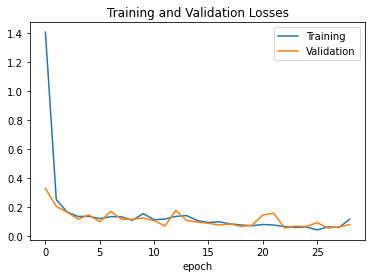

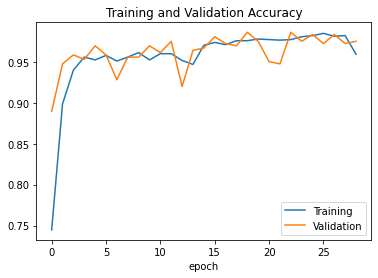

16/16 [==============================] - 124s 8s/step - loss: 0.1663 - accuracy: 0.9153
test loss: 0.1663437932729721 test acc: 0.9152892827987671


In [ ]:
# Keys for graph plot
history.history.keys()

# Plot graph between training loss and validation loss. If loss is reducing, the model is working well and data is fitted well. 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation Losses')
plt.xlabel('epoch')
plt.show()

# Plot graph between training and validation accuraccy. This should increase with epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')
plt.show()

# Get results 
test_loss, test_acc = CNNmodel.evaluate(test_generator)
print('test loss: {} test acc: {}'.format(test_loss, test_acc))


CNN-SVM Analysis:

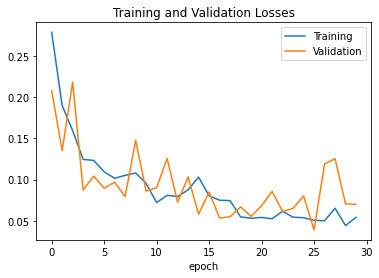

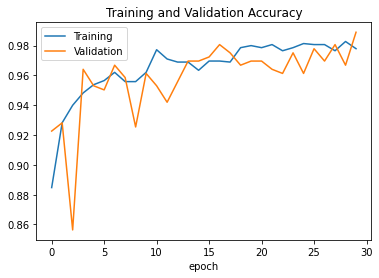

16/16 [==============================] - 14s 861ms/step - loss: 0.1294 - accuracy: 0.9711
test loss: 0.12943123281002045 test acc: 0.9710744023323059


In [ ]:
SVMhistory.history.keys()

plt.plot(SVMhistory.history['loss'])
plt.plot(SVMhistory.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation Losses')
plt.xlabel('epoch')
plt.show()

plt.plot(SVMhistory.history['accuracy'])
plt.plot(SVMhistory.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')
plt.show()

# Get results 
test_loss, test_acc = SVMmodel.evaluate(test_generator)
print('test loss: {} test acc: {}'.format(test_loss, test_acc))

Save Non-Callback Models:

In [ ]:
CNNmodel.save(CNN_saved_dir)

SVMmodel.save(CNNSVM_saved_dir)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/covidData/Saved_CNN_Model/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/covidData/Saved_CNNSVM_Model/assets


# Predicitions

In [ ]:
uploaded = files.upload()
for filename in uploaded.keys():
  img_path = '/content/' +filename
  img = image.load_img(img_path, target_size=(150,150))
  images = image.img_to_array(img)
  # Expand the shape of array:
  images = np.expand_dims(images,axis=0)

  # Saved model 
  saved_model = keras.models.load_model(default_saved_dir)

  # Use saved model to predict
  prediction = saved_model.predict(images)  

  # Returns 0: covid || 1: normal
  if prediction == 0:
    print('\n',filename,': Covid Detected')
  else:
    print('\n',filename,': No Covid Detected\n')  



Saving covid1.jpg to covid1 (5).jpg
Saving covid2.jpeg to covid2 (5).jpeg
Saving normal1.jpg to normal1 (5).jpg
Saving normal2.jpg to normal2 (5).jpg

 covid1.jpg : Covid Detected

 covid2.jpeg : Covid Detected

 normal1.jpg : No Covid Detected


 normal2.jpg : No Covid Detected

